# Implementation of an Autoencoder (AE)
#### based on PyTorch tutorial https://pytorch.org/tutorials/beginner/basics/intro.html , https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html and https://github.com/patrickloeber/pytorch-examples/blob/master/Autoencoder.ipynb
## Simple linear AE with one layer into hidden (latent) space 748 -> 256 -> 12 and back 12 -> 256 -> 748

#### Build for MINST datasets

###### ***For sc-RNAseq:*** fix enable cuda/GPU (only needed if CPU is to slow), try different optimiser, check for loss function, trying learning rates, nn.ReLU() function may not be the best, checking for overfitting by plotting loss of model and training data, Batch size has to be optimised: https://arxiv.org/abs/1609.04836 , https://arxiv.org/abs/1703.04933 . Maybe we should try a program like https://opendatascience.com/optimizing-pytorch-performance-batch-size-with-pytorch-profiler/ for that on a later stage for performance (not sure if the data will be to large in the future)

In [1]:
#import os
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
batch_size = 64

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=mnist_data,batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=mnist_data,batch_size=batch_size, shuffle=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"   ### needed if Nvidia GPU is available and wanted to use the GPU
print(f"Using {device} device")

Using cuda device


In [4]:
### Building the neural network structure ####
dim_encoder_decoder = 28 * 28

class linear_AE(nn.Module):
    def __init__(self):
        super(linear_AE, self).__init__()

        self.encoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(dim_encoder_decoder, 256),  #### data into the neural network layer (28*28 pixel -> 256 nodes)
            nn.ReLU(),                            #### ReLU(x) = (x)^(+) = max(0,x) 
            nn.Linear(256, 12)
        )
        
        self.decoder = nn.Sequential(             # sequential operation of the following code:
            nn.Linear(12, 256),                   #### decoding laten layer (12 -> 256 nodes)
            nn.ReLU(),      #### 
            nn.Linear(256, dim_encoder_decoder),  #### reconstruction of image (256 -> 748)
            nn.Sigmoid()
        )
        
    def forward(self, x):                         # exicute the endcoder and decoder defined in __init__(self)
        
        endoded = self.encoder(x) 
        decoded = self.decoder(endoded) 
        return endoded, decoded
    


model = linear_AE().to(device) #### this is needed for cuda
print(model)

linear_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [5]:
loss_fn = nn.MSELoss() ###   .CrossEntropyLoss() #           ### nn.MSELoss() (Mean Square Error) for regression tasks

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5)

Epoch:1, Loss:30.7092 ; Train Loss:19.5922
Epoch:2, Loss:18.3018 ; Train Loss:17.1817
Epoch:3, Loss:16.6752 ; Train Loss:16.1048
Epoch:4, Loss:15.8094 ; Train Loss:15.3891
Epoch:5, Loss:15.2260 ; Train Loss:14.9689
Epoch:6, Loss:14.8248 ; Train Loss:14.5762
Epoch:7, Loss:14.5250 ; Train Loss:14.2784
Epoch:8, Loss:14.3080 ; Train Loss:14.0596
Epoch:9, Loss:14.1264 ; Train Loss:13.8606
Epoch:10, Loss:13.9876 ; Train Loss:13.9050


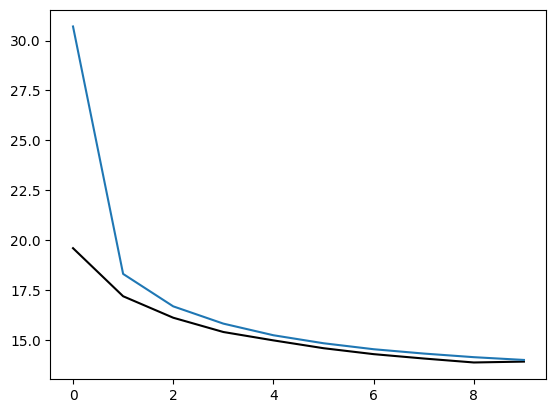

sec:  107.42139649391174
min:  1.7903566082318625
h:  0.029839276803864376


In [6]:
import time
start = time.time()


num_epochs = 10
outputs = []
outputs_test = []
torch.manual_seed(42)
for epoch in range(num_epochs):
    loss_total = 0
    for (X, label) in train_dataloader:
        X = X.reshape(-1, 28*28).to(device)
        latent, pred = model(X)
        loss = loss_fn(pred,X)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    print(f'Epoch:{epoch+1}, Loss:{loss_total:.4f}', end="")
    outputs.append([epoch, loss_total])
    
    loss_test_total = 0
    for (X_test, label) in test_dataloader:
        X_test = X_test.reshape(-1, 28*28).to(device)
        latent_test, pred_test = model(X_test)
        loss_test = loss_fn(pred_test, X_test)
        
        loss_test_total += loss_test.item()
        
    print(f' ; Train Loss:{loss_test_total:.4f}')
    outputs_test.append([epoch, loss_test_total])
    #plt.scatter(epoch, loss_test_total, c="black")
plt.plot([i[0] for i in outputs_test], [i[1] for i in outputs_test],c="black")
plt.plot([i[0] for i in outputs], [i[1] for i in outputs])
plt.show()


end = time.time()
print("sec: ", end - start)
print("min: ", (end - start)/60)
print("h: ", (end - start)/60/60)

5 epochs:

    CPU:

    sec:  68.08382749557495
    min:  1.1347304582595825
    h:  0.018912174304326377

    GPU:  

    sec:  55.43866801261902
    min:  0.923977800210317
    h:  0.015399630003505282

10 epochs:

    CPU:

    sec:  132.21002578735352
    min:  2.203500429789225
    h:  0.03672500716315375

    GPU
    
    sec:  106.07081055641174
    min:  1.7678468426068623
    h:  0.029464114043447707
    
200 epochs:

    GPU
    
    sec:  2132.656932592392
    min:  35.5442822098732
    h:  0.5924047034978867


In [7]:
from tqdm import tqdm
import pandas as pd
encoded_samples = []
for sample in tqdm(mnist_data):
    img = sample[0].unsqueeze(0).reshape(-1, 28*28).to(device)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img, decoded_img  = model(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 60000/60000 [00:24<00:00, 2423.16it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0             3.348142         3.647180         2.863250       -11.924025   
1             9.524878         1.612327        -3.651531       -17.907257   
2             2.534952        -4.228092        -0.675275         1.590778   
3            -6.951835         5.833334        -4.569663         0.407354   
4             7.655397         2.809820         2.661924        -2.382236   
...                ...              ...              ...              ...   
59995         1.476117         5.383806         4.985837        -7.173026   
59996         4.988414         8.078111         4.434209        -8.415672   
59997         2.908334         4.630013        13.111884        -7.035821   
59998         1.087361         5.471835        -4.821531        -6.515716   
59999        -0.272629        -1.029043        -3.870151        -7.884120   

       Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0             3.320311         0.996979        -8.684043        -2.491575   
1             1.890130         8.641808       -10.241158        10.866477   
2            10.967268        -5.638310         3.699641         2.462754   
3             2.706494         2.115563        11.301405        -3.756397   
4             9.757800         1.322408        18.316128        -3.859670   
...                ...              ...              ...              ...   
59995        17.019316         0.854192         0.367349         1.702670   
59996        14.128607        -9.152873        -9.296318         3.537838   
59997        10.200988         4.547142        -0.387629         2.136205   
59998        -2.024746         8.734257        -1.151128         8.597347   
59999         4.835968         9.170740         2.946041         6.522028   

       Enc. Variable 8  Enc. Variable 9  Enc. Variable 10  Enc. Variable 11  \
0            19.564932        -6.133955         -0.149920         -0.792609   
1             0.373896        -2.977419         -7.731672          0.743392   
2            -4.997289         3.234816         -6.063858         -3.137290   
3            10.612851        -8.824351         12.366940          6.643992   
4             3.929642         9.859610         -2.607200          3.366267   
...                ...              ...               ...               ...   
59995         6.829361       -13.103426          6.937189         -1.288814   
59996         9.591084       -13.176722         -4.567747          0.784864   
59997        13.439513        -1.871725         -5.394626         -6.520496   
59998         2.406066        -1.644407        -10.185832          8.086984   
59999         3.659153        -4.688770          9.802331          1.848777   

       label  
0          5  
1          0  
2          4  
3          1  
4          9  
...      ...  
59995      8  
59996      3  
59997      5  
59998      6  
59999      8  

[60000 rows x 13 columns]

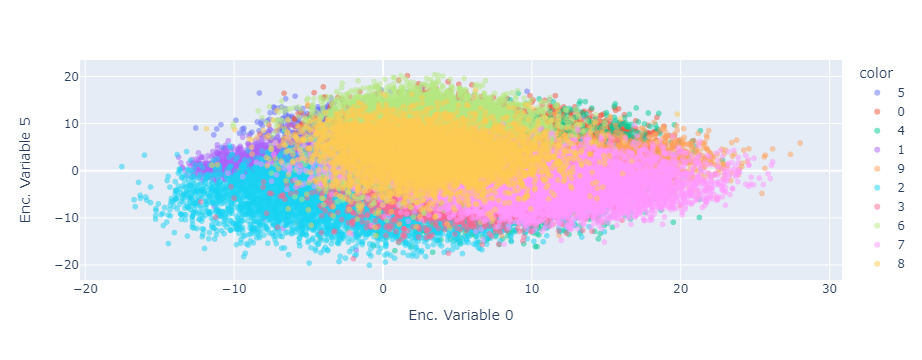

In [10]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 5', 
           color=encoded_samples.label.astype(str), opacity=0.5)

In [9]:
torch.save(model, 'model_oneLayer_AE.pth')